In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    %load_ext tensorboard
except Exception:
    pass

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
keras = tf.keras
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0-rc1


In [0]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
!mkdir data
!tar zxvf cifar10.tgz -C data/

In [2]:
import pathlib
import os

cifar10_dir = 'data/cifar10/'
data_root = pathlib.Path(cifar10_dir)

class_names = sorted([e.name for e in (data_root/'train').iterdir() if e.is_dir()])
class_names_to_label = {name: label for label, name in enumerate(class_names)}
label_to_class_names = {label: name for label, name in enumerate(class_names)}

class_names_to_label

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [0]:
import random
all_image_paths = list(data_root.glob('*/*/*.png'))

random.shuffle(all_image_paths)

train_image_paths, train_image_labels, test_image_paths, test_image_labels = [], [], [], []

for path in all_image_paths:
    if path.parent.parent.name == 'train':
        train_image_paths.append(str(path))
        train_image_labels.append(class_names_to_label[path.parent.name])
        
    elif path.parent.parent.name == 'test':
        test_image_paths.append(str(path))
        test_image_labels.append(class_names_to_label[path.parent.name])

In [0]:
from functools import partial

IMG_SHAPE = (224, 224)
BATCH_SIZE = 64


def load_and_preprocess_image(image_path, label, img_shape):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, img_shape)
    image = keras.applications.resnet_v2.preprocess_input(image)
    # image = tf.cast(image, tf.float32) / 127.5 - 1
    # image = tf.cast(image, tf.float32) / 255
    
    return image, label


def create_dataset(file_paths, labels, epochs=1, batch_size=64, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(partial(load_and_preprocess_image, img_shape=IMG_SHAPE), num_parallel_calls=AUTOTUNE)
    if train:
        dataset = dataset.cache(filename='./cache.tf-data')
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

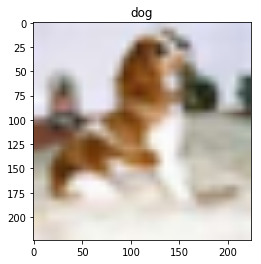

In [6]:
import matplotlib.pyplot as plt

ds = create_dataset(train_image_paths, train_image_labels, batch_size=BATCH_SIZE)

for batch, labels in ds.take(1):
    plt.figure()
    plt.imshow((batch[0] + 1) / 2)
    plt.title(label_to_class_names[labels[0].numpy()])

In [0]:
def create_model(nr_classes):
    base_model = keras.applications.resnet_v2.ResNet50V2(weights="imagenet", include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
    mx = keras.layers.GlobalMaxPooling2D()(base_model.output)
    out = tf.keras.layers.Concatenate()([avg, mx])
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Dropout(0.25)(out)
    out = keras.layers.Dense(512, activation="relu")(out)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Dropout(0.25)(out)
    out = keras.layers.Dense(nr_classes, activation="softmax")(out)
    
    model = keras.models.Model(inputs=base_model.input, outputs=out)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.003)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model


def unfreeze(model):
    model.trainable = True
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [25]:
model = create_model(len(class_names))
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [26]:
FREEZED_EPOCHS = 10

train_ds = create_dataset(train_image_paths, train_image_labels, epochs=FREEZED_EPOCHS, batch_size=BATCH_SIZE, train=True)
test_ds = create_dataset(test_image_paths, test_image_labels, epochs=FREEZED_EPOCHS, batch_size=BATCH_SIZE, train=False)

steps_per_epoch = len(train_image_paths) // BATCH_SIZE
validation_steps = len(test_image_paths) // BATCH_SIZE

history = model.fit(train_ds,
                    epochs = FREEZED_EPOCHS,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = test_ds, 
                    validation_steps = validation_steps,
                    callbacks = [])

Train for 781 steps, validate for 156 steps
Epoch 1/10
781/781 [==============================] - 221s 283ms/step - loss: 0.6550 - accuracy: 0.7832 - val_loss: 0.6835 - val_accuracy: 0.8132
Epoch 2/10
781/781 [==============================] - 210s 269ms/step - loss: 0.4631 - accuracy: 0.8388 - val_loss: 0.8289 - val_accuracy: 0.7857
Epoch 3/10
781/781 [==============================] - 209s 268ms/step - loss: 0.4059 - accuracy: 0.8572 - val_loss: 0.7403 - val_accuracy: 0.8079
Epoch 4/10
781/781 [==============================] - 208s 266ms/step - loss: 0.3622 - accuracy: 0.8715 - val_loss: 0.9959 - val_accuracy: 0.7797
Epoch 5/10
781/781 [==============================] - 206s 263ms/step - loss: 0.3309 - accuracy: 0.8834 - val_loss: 0.7515 - val_accuracy: 0.8216
Epoch 6/10
781/781 [==============================] - 203s 260ms/step - loss: 0.2979 - accuracy: 0.8927 - val_loss: 0.9338 - val_accuracy: 0.7978
Epoch 7/10
781/781 [==============================] - 204s 262ms/step - loss: 0.